In [12]:
import numpy as np
import scipy
import pandas as pd
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt

https://www.kaggle.com/code/renjithmadhavan/credit-card-fraud-detection-using-python

In [13]:
class garchOneOne(object):
       
    def __init__(self, logReturns):
        self.logReturns = logReturns * 100
        self.sigma_2 = self.garch_filter(self.garch_optimization())
        self.coefficients = self.garch_optimization()
        
    def garch_filter(self, parameters):
        "Returns the variance expression of a GARCH(1,1) process."
        
        # Slicing the parameters list
        omega = parameters[0]
        alpha = parameters[1]
        beta = parameters[2]
        
        # Length of logReturns
        length = len(self.logReturns)
        
        # Initializing an empty array
        sigma_2 = np.zeros(length)
        
        # Filling the array, if i == 0 then uses the long term variance.
        for i in range(length):
            if i == 0:
                sigma_2[i] = omega / (1 - alpha - beta)
            else:
                sigma_2[i] = omega + alpha * self.logReturns[i-1]**2 + beta * sigma_2[i-1]
        
        return sigma_2 
        
    def garch_loglikehihood(self, parameters):
        "Defines the log likelihood sum to be optimized given the parameters."
        length = len(self.logReturns)
        
        sigma_2 = self.garch_filter(parameters)
        
        loglikelihood = - np.sum(-np.log(sigma_2) - self.logReturns**2 / sigma_2)
        return loglikelihood
    
    def garch_optimization(self):
        "Optimizes the log likelihood function and returns estimated coefficients"
        # Parameters initialization
        parameters = [.1, .05, .92]
        
        # Parameters optimization, scipy does not have a maximize function, so we minimize the opposite of the equation described earlier
        opt = scipy.optimize.minimize(self.garch_loglikehihood, parameters,
                                     bounds = ((.001,1),(.001,1),(.001,1)))
        
        variance = .01**2 * opt.x[0] / (1 - opt.x[1] - opt.x[2])   # Times .01**2 because it concerns squared returns
        
        return opt.x #np.append(opt.x, variance)

In [14]:
# Downloading data
SPX = yf.download('^GSPC', start = '2005-01-01', interval = '1d')
CAC = yf.download('^FCHI', start = '2005-01-01', interval = '1d')
VIX = yf.download('^VIX', start = SPX.index[1], interval = '1d')
# Calculating log returns
SPX['log_returns'] = np.log(SPX['Adj Close']) - np.log(SPX['Adj Close'].shift(1))
CAC['log_returns'] = np.log(CAC['Adj Close']) - np.log(CAC['Adj Close'].shift(1))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [15]:
# Estimation using our previously coded classes
modelSPX = garchOneOne(SPX['log_returns'][1:])
modelCAC = garchOneOne(CAC['log_returns'][1:])
# Fitting using the arch_model package
arch_mSPX = arch_model(SPX['log_returns'][1:] * 100, mean = 'Zero', vol = 'GARCH')
arch_mSPX = arch_mSPX.fit()
arch_mCAC = arch_model(CAC['log_returns'][1:] * 100, mean = 'Zero', vol = 'GARCH')
arch_mCAC = arch_mCAC.fit()
# Extracting confidence intervals
conf_int_SPX = pd.DataFrame(arch_mSPX.conf_int(alpha = .2))
conf_int_CAC = pd.DataFrame(arch_mCAC.conf_int(alpha = .2))
# Creating the test
conf_int_SPX['garchOneOne'] = modelSPX.coefficients#[:-1]
conf_int_CAC['garchOneOne'] = modelCAC.coefficients#[:-1]
conf_int_SPX['Test'] = np.where(conf_int_SPX['garchOneOne'] < conf_int_SPX['upper'], np.where(conf_int_SPX['garchOneOne'] > conf_int_SPX['lower'], "Ok", "Not ok"), "Not ok") 
conf_int_CAC['Test'] = np.where(conf_int_CAC['garchOneOne'] < conf_int_CAC['upper'], np.where(conf_int_CAC['garchOneOne'] > conf_int_CAC['lower'], "Ok", "Not ok"), "Not ok")

/var/folders/l6/8b55cv6j40b20nltsdxdq57h0000gn/T/ipykernel_19985/3574151730.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_2[i] = omega + alpha * self.logReturns[i-1]**2 + beta * sigma_2[i-1]


Iteration:      1,   Func. Count:      5,   Neg. LLF: 2776411893.1490126
Iteration:      2,   Func. Count:     11,   Neg. LLF: 9293.77520780344
Iteration:      3,   Func. Count:     17,   Neg. LLF: 6786.033652167882
Iteration:      4,   Func. Count:     22,   Neg. LLF: 6660.214446738113
Iteration:      5,   Func. Count:     27,   Neg. LLF: 6836.245821788983
Iteration:      6,   Func. Count:     32,   Neg. LLF: 6645.138326297792
Iteration:      7,   Func. Count:     36,   Neg. LLF: 6645.130471533988
Iteration:      8,   Func. Count:     40,   Neg. LLF: 6645.130423640894
Iteration:      9,   Func. Count:     44,   Neg. LLF: 6645.130422972657
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6645.130422972657
            Iterations: 9
            Function evaluations: 44
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2820549778.360234
Iteration:      2,   Func. Count:     12,   Neg. LLF: 10432.377435479548


Text(0.5, 1.0, 'GARCH(1,1) processes and VIX')

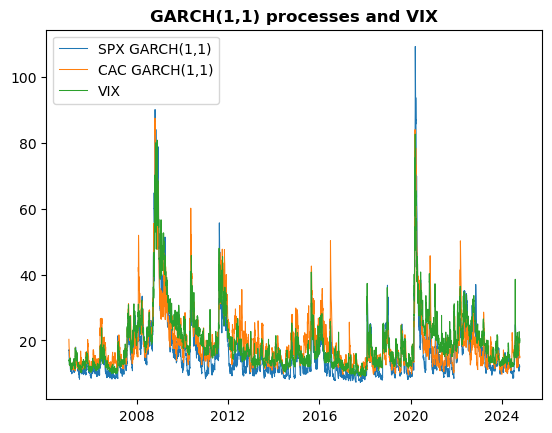

In [16]:
%matplotlib inline
# Transforming data to pandas dataframe
    # + Annualizing volatilities
    # + Indexing by date
dfSPX = pd.DataFrame(np.sqrt(modelSPX.sigma_2*252), index = SPX.index[1:])
dfCAC = pd.DataFrame(np.sqrt(modelCAC.sigma_2*252), index = CAC.index[1:])
# Plotting the data
plt.plot(dfSPX, label = 'SPX GARCH(1,1)', linewidth = .75)
plt.plot(dfCAC, label = 'CAC GARCH(1,1)', linewidth = .75)
plt.plot(VIX.Close, label = 'VIX', linewidth = .75)
plt.legend()
plt.title('GARCH(1,1) processes and VIX', fontweight = 'bold')

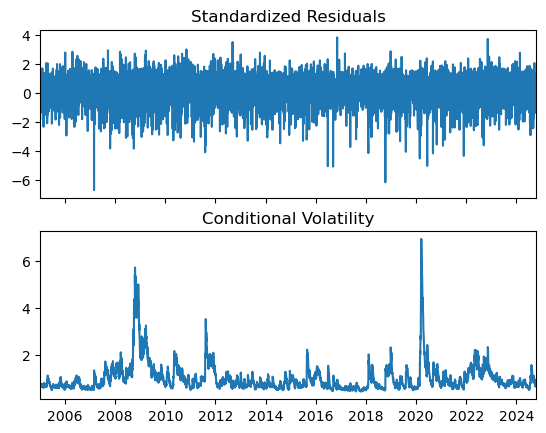

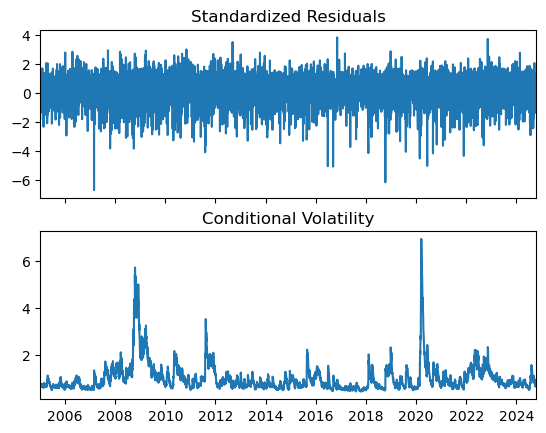

In [17]:
arch_mSPX.plot()